# Tutorial 3 - DLS Sensor Basic Usage


This tutorial will walk through how to convert RedEdge data from raw images to radiace and then use the DLS information in the image metadata to convert that to reflectance.


# Remote Sensing Theory

In [Tutorial 1](./MicaSense%20Image%20Processing%20Tutorial%201.html) we covered conversion of the image radiance to reflecance using the average radiance from an area of a specially made lambertian reflectance panel.  As we did not get very far into remote sensing theory, we will cover that some here as we move on to the more complex problem of using the data from the RedEdge Downwelling Light Sensor (DLS).  To get started, we will review some of the fundamental measurements in remote sensing.

## Definition of Terms


The DLS measures the energy coming from the sky, while the camera measures the energy coming from the fields below.  The property that we are generally looking to estimate in agricultural remote sensing is the surface reflectance of the plants and ground below the sensor. 

The MicaSense RedEdge measures spectral radiance, a measure of the power incident on the CMOS image sensor at each pixel, and has units power per unit area per unit bandwidth per unit solid angle (W/m^2/nm/sr). We will call the radiance image L.

The MicaSense Downwelling Light Sensor (DLS) measures incoming spectral irradiance on the top surface of the device for the same 5 spectral bands as the camera. Irradiance has the units of power per unit area per unit bandwidth, or Watts per meter squared per nanometer (W/m^2/nm). We will call this downwelling quantity I.

If we look closely at the units, they differ by the last term - the unit over solid angle. This is because each pixel of the camera sensor only sees a specific solid angle, while the dls detector has a specific area.  


## Understanding the measurements

In order to use downwelling irradiance and upwelling radiance to determine reflectance, we simply need to divide pi times the irradiance by the radiance.  Our units cancel out, and we are left with the unitless quantity of reflectance.  However, there is one caveat.  In most systems, the DLS is not held level to the ground at all times, so the amount of light that shines on it's surface changes as the aircraft moves about.  In oder for that simple math to work, it's necessary that the irradiance and radiance be compensated for a very important property: the illumination angle.  

Both the radiance and irradiance are sensitive to changes in the direction of the lighting. Both quantites decrease with the cosine of the angle from the surface normal, eventually reaching zero when the light source is parallel to the surface. So when measuring irradiance, this effect needs to be corrected in order to estimate the actual irradiance.

## Different types of irradiance

To complicate matters further, the light reaching the DLS and the ground is not coming from a single source, even under sunny conditions.  The direct sunlight provides what we will call the direct source, resulting in a direct irradiance `I_direct`.  The rest of the (usually blue) sky provides what we term the indirect, or diffuse, irradiance which we will call `I_diffuse`.  Under even the sunniest conditions with the summer sun directly overhead, only about 85% of the light is direct, while the other 15% is diffuse, which we will express as the ratio 6:1.  Under thin cloud conditions, this ratio drops to close 1:1, meaning half of the measured irradiance is coming from parts of the sky other than the direction of the sun. The ratio goes even lower under fully cloudy skies, becoming fully diffuse.

As we ultimately want to estimate the time-varying irradiance, we will need to estimate both the direct and diffuse irradiance terms as well as correct for the cosine effect of the DLS sensor itself.

## Sensor-specific challenges

There's one final piece of theory required that pertains to irradiance sensing, and that is the Fresnel Effect.  The Fresnel Effect describes a physical property of the diffuser that gathers light on top of the DLS.  This effect results from the fact that much of the light striking the diffuser is reflected, and the amount reflected changes with the angle of the incident light.  So, instead of our diffuser behaving as a perfect cosine detector, we need to also compensate for the material imperfections.

## DLS pose estimation

An onboard orientation sensor provides a fairly rough version of the earth-fixed orientation of the DLS.  The quality of this orientation varies based on the quality of the sensor installation and calibration, but in even the best cases it has a few degrees of error. If the DLS and the camera are mounted fixed to one another, the photogrammetric workflow can be used to augment the orientation of the irradiance sensor.  Our examples here will use the sensor measurements directly, but significant improvements can be made using the very precise angles photorammetry can provide.

## Radiometric calibration options

As we've discussed in the first tutorial, the method of using a calibrated reflectance panel is the scientific standard for remote sensing measurements. Spectroradiometers which cost tens of thousands of dollars are calibrated in this method in the field.  Panels images may also be used both before and after each flight to track slowly changing solar irradiance. In many cases of direct sunlight with no clouds, panel images can provide the best results when taken before and after each flight. As the diffuse lighting increases, the utility of the DLS increases as well.

In cases of more varied irradiance, the DLS can be used for irradiance estimation, using only the internal pose estimation.  The DLS irradiance can be be used in conjunction with panels to ensure that the DLS and panel measurements match at the time of panel capture.  In order for this to be effective, it's important that the DLS and panel are exposed to the same irradiance.  This is best accomplished by ensuring panel images are taken with the operator's back to the sun and the operator shadow next to the panel. The aircraft and operator should block as little of the sky as possible.

Finally, in fixed mount systems, the photogrammetric angles can be used, along with the offset between the camera and DLS sensors, to most accurately estimate irradiance. This can again be coupled with one or more panel measurements for best radiometric results.

# Putting it all Together

Below, we will use the `micasense.Capture` class to load a set of images and use tilt-compensated DLS irradiance data to roughly translate those images to reflectance. We will then compare these to the known reflectances of a lambertian panel, and develop a site-specific compensation factor to tie together the DLS irradiance and camera radiance measurements through the panel.

## Accessing and processing DLS data

Below, we show how to access DLS data and compute the minimum required corrections to the DLS data for use.  The code in this cell is present in the `micasense.dls` library, and is used by the `Image` and `Capture` class to expose corrected DLS data.  If your intent is to simply use this code to correct your data, you can skip this section and access pose-corrected DLS data through the `capture.dls_irradiance()` method.

For the purpose of this tutorial, we assume a constant irradiance (over time) and a ratio of direct to diffuse irradiance of 6:1.  These assumptions only hold approximately, and only for clear sky. Cloud cover can lead to dramatically different results. 

## Loading Captures

In [2]:
import numpy as np
import micasense.dls as dls

import os, glob
import micasense.capture as capture

images_path = os.path.join('.','data','0000SET','000')
image_names = glob.glob(os.path.join(images_path,'IMG_0000_*.tif'))
cap = capture.Capture.from_filelist(image_names)
# set panel corners manually if zbar is not installed
panelCorners = [[[809,613],[648,615],[646,454],[808,452]],
                [[772,623],[613,625],[610,464],[770,462]],
                [[771,651],[611,653],[610,492],[770,490]],
                [[829,658],[668,659],[668,496],[829,496]],
                [[807,632],[648,634],[645,473],[805,471]]]

cap.set_panelCorners(panelCorners)

## Computing Solar orientation

In [3]:
# Define DLS sensor orientation vector relative to dls pose frame
dls_orientation_vector = np.array([0,0,-1])
# compute sun orientation and sun-sensor angles
(
    sun_vector_ned,    # Solar vector in North-East-Down coordinates
    sensor_vector_ned, # DLS vector in North-East-Down coordinates
    sun_sensor_angle,  # Angle between DLS vector and sun vector
    solar_elevation,   # Elevation of the sun above the horizon
    solar_azimuth,     # Azimuth (heading) of the sun
) = dls.compute_sun_angle(cap.location(),
                      cap.dls_pose(),
                      cap.utc_time(),
                      dls_orientation_vector)

## Correcting DLS readings for orientations

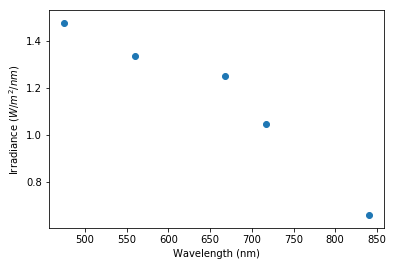

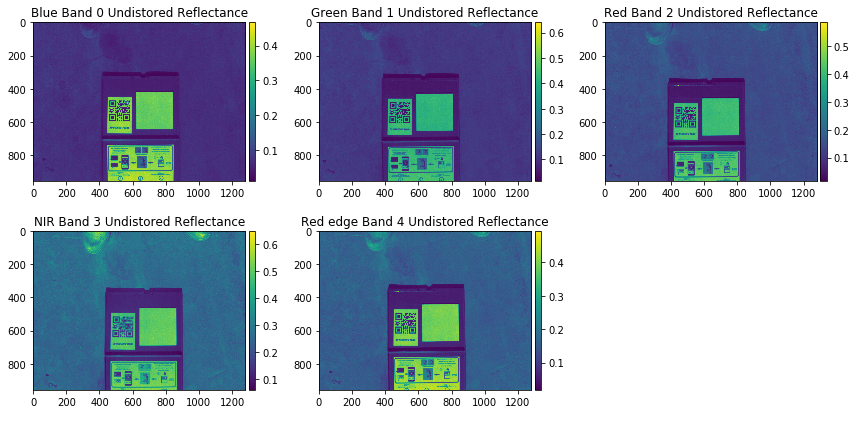

In [4]:
# Since the diffuser reflects more light at shallow angles than at steep angles,
# we compute a correction for this
fresnel_correction = dls.fresnel(sun_sensor_angle)

# Now we can correct the raw DLS readings and compute the irradiance on level ground
dls_irradiances = []
center_wavelengths = []
for img in cap.images:
    dir_dif_ratio = 6.0
    percent_diffuse = 1.0/dir_dif_ratio
    # measured Irradiance / fresnelCorrection
    sensor_irradiance = img.dls_irradiance / fresnel_correction
    untilted_direct_irr = sensor_irradiance / (percent_diffuse + np.cos(sun_sensor_angle))
    # compute irradiance on the ground using the solar altitude angle
    dls_irr = untilted_direct_irr * (percent_diffuse + np.sin(solar_elevation))
    dls_irradiances.append(dls_irr)
    center_wavelengths.append(img.center_wavelength)

import matplotlib.pyplot as plt
plt.scatter(center_wavelengths,dls_irradiances)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance ($W/m^2/nm$)')
plt.show();

cap.plot_undistorted_reflectance(dls_irradiances)

## Tying the camera and DLS together via Panels

Finally, if we want to use the panel as the ultimate reference tying the panel and the DLS readings together with a known lambertian reflector, we can calculate a DLS factor which we can then apply to DLS derived irradiances over the whole flight.  

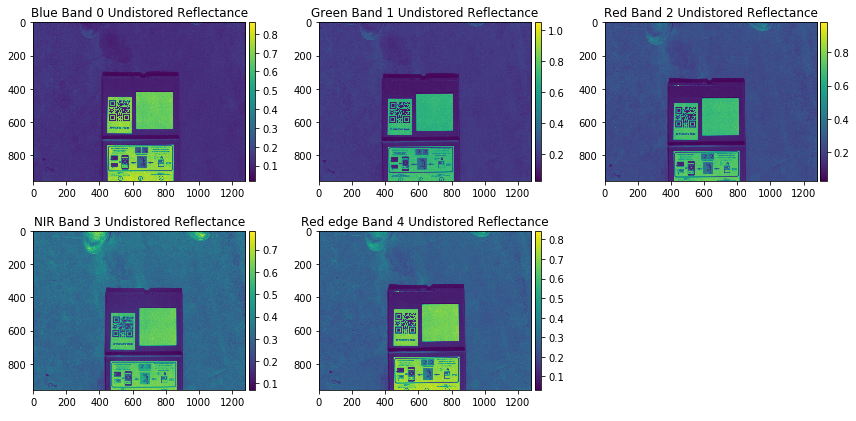

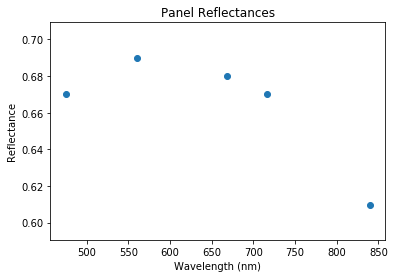

In [5]:
import math

panel_reflectance_by_band = [0.67, 0.69, 0.68, 0.61, 0.67] #RedEdge band_index order

panel_radiances = np.array(cap.panel_radiance())
irr_from_panel = math.pi * panel_radiances / panel_reflectance_by_band
dls_correction = irr_from_panel/dls_irradiances
cap.plot_undistorted_reflectance(dls_irradiances*dls_correction)

plt.scatter(cap.center_wavelengths(), cap.panel_reflectance())
plt.title("Panel Reflectances")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.show()



# Future improvements

While the need to compensate the DLS for movement increases the complexity of the problem, it also provides us more information than might be available for other diffuser types. This is because as the DLS moves about on the aircraft, it provides many measurements per second that should all have consistent effects assuming the light isn't changing over those very fast measurements. This movement can then be used to develop an irradiance series which uses all of the available information from the on board sensors.  A future tutorial will provide an overview of some methods for improving irradiance sensing further.

---
Copyright (c) 2017-2018 MicaSense, Inc.  For licensing information see the [project git repository](https://github.com/micasense/imageprocessing)